# Tarea 5 - Clasificadores

In [1]:
import numpy as np
from os import listdir
from sklearn.model_selection import cross_validate

In [2]:
from pybalu.feature_extraction import lbp_features, hog_features
from pybalu.feature_selection import clean, sfs
from pybalu.feature_transformation import normalize
from pybalu.io import imread

Para todos los experimentos se realiza la obtención de la información de la misma manera

In [3]:
label_dict = {'N': 0, 'P': 1}
pedestrians_file_names = [i for i in listdir('pedestrians') if i.endswith('png')]
y = np.array([label_dict[i[0]] for i in pedestrians_file_names])
pedestrians_paths = [f'pedestrians/{i}' for i in pedestrians_file_names]

Se utiliza `flatten = True` para tener las imagenes en escala de grises, dada las características del problema a clasificar, en el cual no afecta el color ya que puede ser incluso una falsa correlación, sino que por ejemplo la posición.

In [4]:
X = np.array([imread(i, flatten=True) for i in pedestrians_paths])

Como no hay set de test y es un análisis sobre todo el set de entrenamiento, no se hace una división. Para ser consistente con la nomenclatura empleada durante todo el curso, igual llamaré `X_train` e `y_train` a los conjuntos de datos

In [5]:
X_train = X
y_train = y

Se agrega la siguiente función para mostrar los resultados de manera amigable

In [6]:
def scores(accuracies, precisions, recalls):
    print('Avg scores:')
    print(f'Accuracy: {np.mean(accuracies)}, Precision: {np.mean(precisions)}, Recall: {np.mean(recalls)}')
    print('\nStd scores:')
    print(f'Accuracy: {np.std(accuracies)}, Precision: {np.std(precisions)}, Recall: {np.std(recalls)}')

## Extracción

Lo primero es extraer características, que serán comunes para los 3 clasificadores a realizar

La estrategia es extraer LBP, con 3 divisiones tanto horizontales como verticales, y con un mapeo variante a rotación pero uniforme, lo que implica que se toma en consideración que pueden haber variaciones de brillo entre una imagen y otra.

Además se extrae HOG, de modo de considerar las direcciones de los elementos en las imágenes, que puede ser útil considerando que los umanos suelen tener características corporeas similares a grandes rasgos. Se utiliza la misma división vertical y horizontal, y 8 bins, dado que se pretenden ver las 8 direcciones.

In [7]:
X_train_lbp = np.array([lbp_features(i, hdiv=3, vdiv=3, mapping='nri_uniform') for i in X_train])

In [8]:
X_train_hog = np.array([hog_features(i, v_windows=3, h_windows=3, n_bins=8) for i in X_train])

Se concatenan ambos conjuntos de características

In [9]:
X_train_features = np.concatenate((X_train_lbp, X_train_hog), axis=1)

Se realiza una limpieza de columnas que no entregan información utilizando clean

In [10]:
X_train_clean_indexes = clean(X_train_features)
X_train_clean = X_train_features[:, X_train_clean_indexes]

Se normaliza pues algunos clasificadores esperan datos normalizados, como por ejemplo redes neuronales

In [11]:
X_train_norm, norm_a, norm_b = normalize(X_train_clean)

Se realiza una selección de 50 características con SFS

In [12]:
N_FEATURES = 50
X_train_sfs_indexes = sfs(X_train_norm, y_train, n_features=N_FEATURES, method="fisher", show=True)

Selecting Features: 100%|██████████| 50.0/50.0 [00:14<00:00, 3.35 features/s]


In [13]:
X_train_sfs = X_train_norm[:, X_train_sfs_indexes]

## Opción 1: LBP + HOG -> SFS -> KNN

La primera opción como clasificador es usar KNN justo después de la selección, se utilizarán 2 vecinos.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
knn = KNeighborsClassifier(n_neighbors=2)

Saco los puntajes con validación cruzada de 10 folds

In [16]:
cross_val_scores = cross_validate(knn, X_train_sfs, y_train, cv=10, scoring=['accuracy', 'precision', 'recall'])

In [17]:
cross_val_accuracies_knn = cross_val_scores['test_accuracy']
cross_val_precisions_knn = cross_val_scores['test_precision']
cross_val_recalls_knn = cross_val_scores['test_recall']

Con el clasificador de KNN de 2 vecinos se obtienen los siguientes valores para cada métrica y su desviación

In [18]:
scores(cross_val_accuracies_knn, cross_val_precisions_knn, cross_val_recalls_knn)

Avg scores:
Accuracy: 0.9525, Precision: 0.9664302059496569, Recall: 0.9400000000000001

Std scores:
Accuracy: 0.020766559657295163, Precision: 0.04035354754335639, Recall: 0.02999999999999998


## Opción 2: LBP + HOG -> SFS -> SVM

Como segunda opción se explorará utilizar un SVM en vez de un clasificador de vecinos cercanos. Para ello, no solo se verán los desempeños del clasificador con validación cruzada, sino que también se utilizará `GridSearchCV` para determinar los parámetros del clasificador. Con esto se usa la validación de manera de que ayuda para elegir los parámetros y no solo para ver los resultados y puntajes

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Al igual que en la tarea anterior, para los valores de $C$ y $\gamma$ del SVM se recomienda utilizar potencias de 2 dentro de ciertos márgenes, basado en [este documento](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf).

La búsqueda entonces se hace sobre esos dominios, y con validación cruzada de 10 folds

In [20]:
C_range = np.power(2, np.linspace(-3, 3, 7))
gamma_range = np.power(2, np.linspace(-10, 1, 12))
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=10)

In [21]:
grid.fit(X_train_sfs, y_train);

In [22]:
print(f'Params: {grid.best_params_}, Accuracy: {grid.best_score_}')

Params: {'C': 0.5, 'gamma': 0.015625}, Accuracy: 0.9925


Los parámetros que se obtienen son esos, y se utilizarán para obtener todos los puntajes

In [23]:
svm = SVC(**grid.best_params_)
cross_val_scores = cross_validate(svm, X_train_sfs, y_train, cv=10, scoring=['accuracy', 'precision', 'recall'])

In [24]:
cross_val_accuracies_svm = cross_val_scores['test_accuracy']
cross_val_precisions_svm = cross_val_scores['test_precision']
cross_val_recalls_svm = cross_val_scores['test_recall']

Para un SVM simple con valor de $C=0.5$ y $\gamma=2^{-6}$, los resultados para cada métrica con sus desviaciones son los siguientes:

In [25]:
scores(cross_val_accuracies_svm, cross_val_precisions_svm, cross_val_recalls_svm)

Avg scores:
Accuracy: 0.9925, Precision: 0.9904761904761905, Recall: 0.9949999999999999

Std scores:
Accuracy: 0.01145643923738961, Precision: 0.019047619047619067, Recall: 0.015000000000000015


## Opción 3: LBP + HOG -> SFS -> MLP

Nuevamente utilizando la misma extracción y selección se procede a clasificar, pero ahora con redes neuronales

In [26]:
from sklearn.neural_network import MLPClassifier

De modo similar a lo anterior, se procede a hacer una búsqueda con validación cruzada de los parámetros adecuados, se escogen de antemano ciertos parámetros que descartar, ya que probar todos es muy costoso computacionalmente.

In [27]:
parameters = {
    'solver': ['lbfgs'],
    'learning_rate': ['invscaling', 'adaptive'],
    'activation': ['logistic', 'tanh', 'relu'],
    'alpha': 10.0 ** -np.arange(1, 5),
    'hidden_layer_sizes': [(5, 5), (10, 10), (15, 15)],
}
nn_grid = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=10)

In [28]:
nn_grid.fit(X_train_sfs, y_train);

In [29]:
print(f'Params: {nn_grid.best_params_}, Accuracy: {nn_grid.best_score_}')

Params: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (15, 15), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}, Accuracy: 0.9925


Como depende fuértemente del estado aleatorio inicial, los resultados varían, sin embargo eso se ve mitigado por sacar un promedio de los resultados.

Al igual que en los experimentos anteriores, se procede a obtener los puntajes con este clasificador y los mejores parámetros encontrados.

In [46]:
nn = MLPClassifier(**nn_grid.best_params_)

In [47]:
cross_val_scores = cross_validate(nn, X_train_sfs, y_train, cv=10, scoring=['accuracy', 'precision', 'recall'])

In [48]:
cross_val_accuracies_nn = cross_val_scores['test_accuracy']
cross_val_precisions_nn = cross_val_scores['test_precision']
cross_val_recalls_nn = cross_val_scores['test_recall']

Finalmente, con una red neuronal simple como clasificador, se obtienen puntajes cercanos al 100%. Los resultados son los siguientes:

In [49]:
scores(cross_val_accuracies_nn, cross_val_precisions_nn, cross_val_recalls_nn)

Avg scores:
Accuracy: 0.9924999999999999, Precision: 0.9952380952380953, Recall: 0.9899999999999999

Std scores:
Accuracy: 0.01145643923738961, Precision: 0.014285714285714303, Recall: 0.020000000000000018


## Gráficos comparativos de los rendimientos

In [50]:
import matplotlib.pyplot as plt

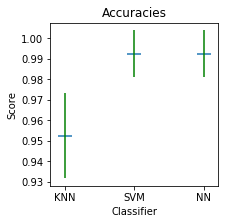

In [51]:
model = ['KNN', 'SVM', 'NN']
score = [cross_val_accuracies_knn.mean(), cross_val_accuracies_svm.mean(), cross_val_accuracies_nn.mean()]
err = [cross_val_accuracies_knn.std(), cross_val_accuracies_svm.std(), cross_val_accuracies_nn.std()]
fig = plt.figure(figsize=(3, 3))
plt.title('Accuracies')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.errorbar(model, score, yerr=err, fmt='none', color='green')
plt.scatter(model, score, marker='_', s=200)
plt.show()

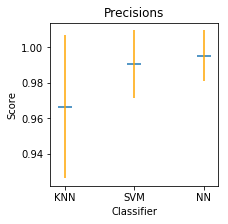

In [52]:
score = [cross_val_precisions_knn.mean(), cross_val_precisions_svm.mean(), cross_val_precisions_nn.mean()]
err = [cross_val_precisions_knn.std(), cross_val_precisions_svm.std(), cross_val_precisions_nn.std()]
fig = plt.figure(figsize=(3, 3))
plt.title('Precisions')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.errorbar(model, score, yerr=err, fmt='none', color='orange', barsabove=False)
plt.scatter(model, score, marker='_', s=200)
plt.show()

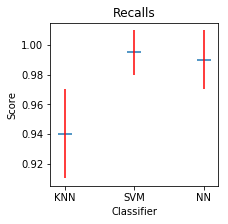

In [53]:
score = [cross_val_recalls_knn.mean(), cross_val_recalls_svm.mean(), cross_val_recalls_nn.mean()]
err = [cross_val_recalls_knn.std(), cross_val_recalls_svm.std(), cross_val_recalls_nn.std()]
fig = plt.figure(figsize=(3, 3))
plt.title('Recalls')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.errorbar(model, score, yerr=err, fmt='none', color='red')
plt.scatter(model, score, marker='_', s=200)
plt.show()